<a href="https://colab.research.google.com/github/Mkenza/project_DL/blob/master/ReID_4_MAKHLOUF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Re-identification with Market 1501 </h1>
 <h2> Kenza MAKHLOUF</h2></center>


L'objectif est pouvoir identifier la personne sous plusieurs points de vue, avec le dataset MARKET 1501 [1].

Pour cela, nous allons tenté de finetune un modèle pré-entraîné avec une triplet loss proposée dans l'article [2]. La structure a été inspirée par celle de VSE++.

**Step 1: Pré-traitement du dataset:**
* Les dossiers contiennent des fichiers et des images qu'on ne veut pas ajouter à l'entraînement, ceux-ci seront supprimés.
* On investigera le nombre d'occurence des identités, pour pouvoir prélever dans chaque batch un nombre équilibré d'instances de même identité.

**Step 2: DataLoader reid_data.py**

Afin d'optimiser l'import et l'encodage des images, nous allons créer une classe Dataset, qui permettra l'import des images dans le bon format (compatible avec le modèle pré-entraîné). On aura par la suite une fonction get_loader, qui retournera un torch DataLoader de ce dataset personnalisé.

**Step 3: Modèle model.py**

Nous allons créer une classe héritant de torch.nn.Module qui aura un modèle pré-entraîné, deux couches denses avec une fonction d'activation ReLu, Adam Optimizer et une fonction loss que nous allons créer.

La classe TripletLoss permet de définir la fonction forward_loss de notre modèle. Celle-ci compare l'exemple positif les plus loins de l'élément anchor avec l'exemple négatif (identité différente) le plus proche. Ceci permet d'éloigner les exemples négatifs les plus durs et rapprocher les exemples positifs.

**Step 4: Entraînement**

Nous allons entraîner le modèle avec les optios définis dans le dictionnaire options, montrer la loss sur l'entraînement, puis calculer le recall@1 sur la validation (le test). Les informations sur la loss, le nombre d'itérations sont disponible dans le logger.

Le code à exécuter est disponible sur le notebook, mais peut aussi être exécuter dans un terminal (train.py avec les arguments dans option, exécuter train.py --h pour plus d'informations)

**Step 5: Evaluation**

Une fonction recall permet le calcul du recall@1 souvent utilisé dans ce contexte de recherche. Il correspond aux de bonnes réponses classées en premier par le modèle. Ainsi, une bonne réponse dans ce contexte est une image d'une personne de même identité.

On peut aussi visualiser les images les plus proches d'un élément selon le modèle, avec la fonction similar_images. 

Ou encore visualiser l'espace encodé des images pour comprendre la représentation du modèle.

--------------------------------------
[1] Liang Zheng, Liyue Shen, Lu Tian, Shengjin Wang, Jingdong Wang, and Qi Tian.
Scalable person re-identification: A benchmark. In Computer Vision, IEEE Inter-
national Conference on, 2015.
10

[2] Alexander Hermans, Lucas Beyer, and Bastian Leibe. In defense of the triplet loss
for person re-identification, 2017, https://arxiv.org/pdf/1703.07737.pdf


### Imports

In [5]:
!pip install tensorboard-logger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import sys
import pickle
import time
import shutil
import torch
import cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from scipy import spatial
from tqdm import tqdm
from argparse import Namespace

import reid_data
from model import ReIdModel
from utils import LogCollector

import logging
import tensorboard_logger as tb_logger

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Le dataset Market contient 5 dossiers:

* bounding_box_{train, test}: BB obtenus avec un Deformable Part Model.
* gt_bbox: BB annotés à la main
* get_query/ query: requêtes pour obtenir des samples

On s'intéressera aux premiers dossiers car ils contiennent respectivement 12936 et 19732 images de taille (128, 64, 3)

In [4]:
import zipfile
with zipfile.ZipFile("drive/MyDrive/Market-1501-v15.09.15.zip", 'r') as zip_ref:
    zip_ref.extractall("Market_data")

### Prétraitement du dataset

  Le dataset contient (notamment le dossier test) plusieurs détection fausses (d'une partie du corps, ou du sol etc.) dont l'identifiant est 0000 ou -1, nous allons d'abord supprimer ces images avant de les donner au modèle pour la partie validation:

In [5]:
for file in os.listdir("Market_data/Market-1501-v15.09.15/bounding_box_test/"):
  if (file.startswith("0000")) or (file.startswith("-1")):
      os.remove(f"Market_data/Market-1501-v15.09.15/bounding_box_test/{file}")

In [6]:
os.remove("Market_data/Market-1501-v15.09.15/bounding_box_test/Thumbs.db")

In [7]:
os.remove("Market_data/Market-1501-v15.09.15/bounding_box_train/Thumbs.db")


### Data Loader
Dans ce projet, nous allons utilisé la librairie pytorch et les dataloader disponibles pour pouvoir encoder par batch les images du dataset et les importée proprement et efficacement (la librairie a été conçu pour que ces actions ne prennent pas beaucoup d'espace et de temps).

Dans le fichier reid_data.py nous avons notre class ReIdDataset où nous avons défini la structure de notre dataset, la fonction collate_fn utilisée par les dataloaders pour obtenir un minibatch des données : dans notre cas il s'agit de (image, indice, identifiant) puis la fonction get_loader pour créer un loader avec notre dataset.

Pour avoir une bonne répartition des identités dans le dataset, nous allons d'abord voir combien de fois chaque identité se répète. Selon la document, une personne est vu avec au moins 2 perspectives, Nous avons donc pour chaque 

In [ ]:
image_folder = "Market_data/Market-1501-v15.09.15/bounding_box_train/"
df = pd.DataFrame({"ids":[ name[:4] for name in os.listdir(image_folder)]})
df2 = df.pivot_table(index = ['ids'], aggfunc ='size')
df2

ids
0002    46
0007     7
0010    11
0011    15
0012     6
        ..
1489     7
1492    15
1495    33
1496    16
1500     9
Length: 751, dtype: int64

In [13]:
def recall(images, ids):
    """
    Calcul du recall@1
    ne tient pas compte de la position de l'image originale dans le ranking (similarité =1 maximale)

    C'est possible d'avoir une image positive classées mieux que l'image originale,
        on veut pas pénaliser le modèle sur cela
    """
    ranks = np.zeros(images.shape[0])
    top1 = np.zeros(images.shape[0])
    scores = np.dot(images, images.T)
    for index in range(images.shape[0]):
        id = ids[index]
        d = scores[index] # shape (1, batch_size) = distance of positive instances with the rest
        inds = np.zeros(d.shape[0]) 
        inds = np.argsort(d)[::-1]
        for i, ind in enumerate(inds):
          if (ids[ind] == id) and (ind!=index): # on ne regarde pas la distance avec l'élément lui-même
            ranks[index] = i
            break

    # Compute metrics

    # rank could be 0, or 1;
    # 0 if positive example is ranked better than original image
    # 1 if it's right after original image
    r1 = 100.0 * len(np.where(ranks <= 1)[0]) / len(ranks)
    return r1

In [82]:
def encode_data(model, data_loader):
    """encoder des images avec un modèle et un dataset donné par le dataloader
    l'encodage se fera par batch
    returns:
    ---------------
    img_embs: images encodées
    ids: liste des identités correspondantes aux images
    r1: recall@1 sur tout le dataset
    r1_mean: recall@1 moyen sur les batches"""
    # switch to evaluate mode
    model.eval()

    print("encoding...")
    # numpy array to keep all the embeddings
    img_embs = None
    r1 = 0
    ids_final = ["" for i in range(len(data_loader.dataset))]
    for i, (images, indexes, ids) in enumerate(tqdm(data_loader)):
        # compute the embeddings
        img_emb = model.forward(images)
        # initialize the numpy arrays given the size of the embeddings
        if img_embs is None:
            img_embs = np.zeros((len(data_loader.dataset), img_emb.size(1)))
        # preserve the embeddings by copying from gpu and converting to numpy
        img_embs[indexes] = img_emb.data.cpu().numpy().copy()
        for i, idx in enumerate(indexes):
          ids_final[idx] = ids[i]

        r1 += recall(img_emb.data.cpu().numpy().copy(), ids)
        # # measure accuracy and record loss
        model.forward_loss(img_emb, ids)

        del images
    
    print("mean recall@1 on batches of validation: ", r1/len(data_loader))
    return img_embs, ids_final, recall(img_embs, ids_final), r1/len(data_loader)

## Model: VGG19 finetuned

Dans cette implémentation, on utilise un modèle pré-entraîné VGG19 dont le classifieur (la dernière couche) a été supprimé, on ajoute deux couches linéaires avec une fonction d'activation ReLu, la sortie est un vecteur de dimension 1024. 

Ce paramètre peut être modifié par l'utilisateur. Il suffit de spécifier `--embed_size` dans la commande dans un terminal, ou changer la valeur dans le dictionnaire `optdict`.

On utilise un optimizer Adam, avec un learning rate de 0.0002, cette valeur peut aussi être personnalisée: `--learning_rate`.


In [81]:
optdict = {"batch_size":32, "cnn_type":'vgg19', "data_path":'Market_data/Market-1501-v15.09.15/bounding_box_train', 
           "embed_size":1024, "learning_rate":0.0002, "margin":.2, "num_epochs":10}

options = Namespace(**optdict)

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)
tb_logger.configure(options.cnn_type+"_reidmodel", flush_secs=5)   

In [52]:
model_cnn = ReIdModel(options)
model_cnn.logger = LogCollector()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
train_loader = reid_data.get_loader(options.data_path, batch_size=options.batch_size)
val_loader = reid_data.get_loader('Market_data/Market-1501-v15.09.15/bounding_box_test', batch_size=100)

## Loss: Triplet Loss


La loss est une triplet loss, où pour chaque exemple dans le batch, on compare la similarité avec l'exemple positif le plus loin selon le modèle, et la similarité avec l'exemple le plus négatif selon le modèle. L'objectif étant d'avoir cet exemple positif plus proche que l'exemple négatif. Ainsi, dans l'encodage, on aura que des exemples positifs dans l'entourage de l'anchor:

scores_anchor contient les similarités avec le reste du batch:

`cost += max(torch.max(scores_anchor[neg])-torch.min(scores_anchor[pos]), 0)
`

On ajoute un margin, spécifié par l'utilisateur (par défaut 0.2), selon les auteurs de [2], l'absence de margin donne de meilleurs résultats, mais nos expériences ont montré que cette valeur est optimale (des entraînements ont été effectuées avec des valeurs entre 1. et 0.002).

## Entraînement:

Nous allons entraîner le modèle sur 10 epochs pour voir l'évolution des performances sur l'entraînement et le test: Nous allons comparer la loss sur l'entraînement et le recall@1 sur le test:

In [7]:
%load_ext autoreload
%autoreload 2

In [83]:
# switch to train mode
model_cnn.train()
r1_list = []
r1_mean_list = []
loss_train = []
for epoch in range(options.num_epochs):
    print(f"Epoch {epoch+1}/{options.num_epochs}: \n")
    for i, train_data in enumerate(tqdm(train_loader)):
        model_cnn.train()
        
        # Update the model
        model_cnn.train_emb(*train_data)
    tb_logger.log_value('epoch', epoch, step=model_cnn.Eiters)
    tb_logger.log_value('step', i, step=model_cnn.Eiters)
    model_cnn.logger.tb_log(tb_logger, step=model_cnn.Eiters)
    print("training loss: ", model_cnn.loss_t.item())
    loss_train.append(model_cnn.loss_t.item())
    _, _, r1, r1_mean = encode_data(model_cnn, val_loader)
    # print("Recall@1 on all 13184 images: ", r1)
    r1_mean_list.append(r1_mean)
    r1_list.append(r1)
torch.save(model_cnn.state_dict(), f"model_{options.cnn_type}.PTH")

Epoch 1/10: 



  0%|          | 0/405 [00:00<?, ?it/s]/content/model.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positive = np.array([np.where(np.array(ids)==id) for id in np.array(ids)]) # shape (batch_size, vary)
/content/model.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  negative = np.array([np.where(np.array(ids)!=id) for id in np.array(ids)]) # shape (batch_size, vary)
100%|██████████| 405/405 [05:45<00:00,  1.17it/s]


training loss:  8.09004020690918
encoding...


100%|██████████| 132/132 [01:39<00:00,  1.32it/s]


mean recall@1 on batches of validation:  88.78030303030303
Epoch 2/10: 



100%|██████████| 405/405 [05:34<00:00,  1.21it/s]


training loss:  8.33221435546875
encoding...


100%|██████████| 132/132 [01:39<00:00,  1.33it/s]


mean recall@1 on batches of validation:  89.59848484848484
Epoch 3/10: 



100%|██████████| 405/405 [05:32<00:00,  1.22it/s]


training loss:  8.12818431854248
encoding...


100%|██████████| 132/132 [01:41<00:00,  1.30it/s]


mean recall@1 on batches of validation:  90.3030303030303
Epoch 4/10: 



100%|██████████| 405/405 [05:34<00:00,  1.21it/s]


training loss:  8.320165634155273
encoding...


100%|██████████| 132/132 [01:41<00:00,  1.30it/s]


mean recall@1 on batches of validation:  89.40151515151516
Epoch 5/10: 



100%|██████████| 405/405 [05:34<00:00,  1.21it/s]


training loss:  8.163599014282227
encoding...


100%|██████████| 132/132 [01:40<00:00,  1.32it/s]


mean recall@1 on batches of validation:  90.0909090909091
Epoch 6/10: 



100%|██████████| 405/405 [05:32<00:00,  1.22it/s]


training loss:  8.294310569763184
encoding...


100%|██████████| 132/132 [01:40<00:00,  1.31it/s]


mean recall@1 on batches of validation:  89.42424242424242
Epoch 7/10: 



100%|██████████| 405/405 [05:32<00:00,  1.22it/s]


training loss:  7.9583048820495605
encoding...


100%|██████████| 132/132 [01:39<00:00,  1.33it/s]


mean recall@1 on batches of validation:  88.89393939393939
Epoch 8/10: 



100%|██████████| 405/405 [05:33<00:00,  1.21it/s]


training loss:  7.677862644195557
encoding...


100%|██████████| 132/132 [01:41<00:00,  1.30it/s]


mean recall@1 on batches of validation:  89.9469696969697
Epoch 9/10: 



100%|██████████| 405/405 [05:33<00:00,  1.21it/s]


training loss:  7.960019111633301
encoding...


100%|██████████| 132/132 [01:40<00:00,  1.31it/s]


mean recall@1 on batches of validation:  89.82575757575758
Epoch 10/10: 



100%|██████████| 405/405 [05:32<00:00,  1.22it/s]


training loss:  8.027436256408691
encoding...


100%|██████████| 132/132 [01:40<00:00,  1.31it/s]


mean recall@1 on batches of validation:  89.18939393939394


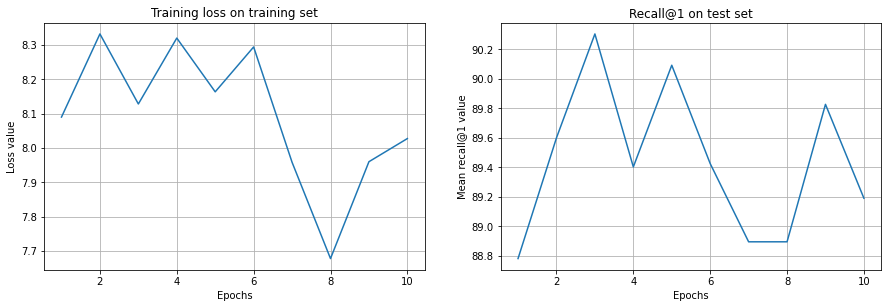

In [7]:
# plot performance metrics
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, 11), loss_train)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.title("Training loss on training set")
plt.subplot(2, 2, 2)
plt.plot(np.arange(1, 11), r1_mean_list)
plt.grid()
plt.title("Recall@1 on test set")
plt.xlabel("Epochs")
plt.ylabel("Mean recall@1 value")
plt.show()

La loss descend bien sur l'entraînement mais on remarque une instabilité du recall@1 moyen sur le test autour de la valeur 85%.

Nous avons entraîné le modèle sur 10 epochs vu le temps de calcul important qu'une loss triplet requiert (1h pour 10 epochs). On devrait l'entraîner sur un nombre plus élevé d'étape pour confirmer s'il y a un overfitting. Auquel, il faudra:
* ajuster le learning rate, avec un decay factor toutes les x epochs.
* ajouter des layers de regularisation (e.g dropout)
* calculer le recall@k sur un batch_size plus grand, il est possible que dans le batch il y a pas de bonnes réponses. L'augmentation de données étant faite uniquement sur le training set.

Nous passons maintenant à d'autres méthodes d'analyse de performance plus intuitives:

### Test pour voir les images similaires selon le modèle:

Une façon de bien comprendre la représentation créer par le modèle est de visualiser les images similaire dans le dataset étant donné une image, nous allons pas tenir en compte la première image, vu qu'elle correspond toujours à l'image originale (les vecteurs sont normalisés, donc la similarité =1 dans ce cas)

In [77]:
def display_similar(scores, ids, data_path, index):
    """
    Visualiser les images les plus similaires à l'image dont l'indice index dans le dataset

    calcul la similarité
    display les 5 images les plus similaires
    """

    d = scores[index] 
    inds = np.zeros(d.shape[0]) 
    inds = np.argsort(d)[::-1] # indexes of most similar
    # plot first three similar 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,10))

    # plot original
    ax = axs.flatten()[0]
    im = cv2.imread(os.path.join(data_path,os.listdir(data_path)[index]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax.imshow(im)
    ax.title.set_text(f"Original")
    # plot first three most similar images
    for i, ax in enumerate(axs.flatten()[1:]):
      im = cv2.imread(os.path.join(data_path,os.listdir(data_path)[inds[i]]))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      ax.imshow(im)
      ax.title.set_text(f"similarity of: {d[inds[i]]}")

In [57]:
ims, ids, r1 = encode_data(model_cnn, val_loader)
scores = np.dot(ims, ims.T)

encoding...


100%|██████████| 132/132 [01:42<00:00,  1.29it/s]


mean recall@1 on batches of validation:  88.47727272727273


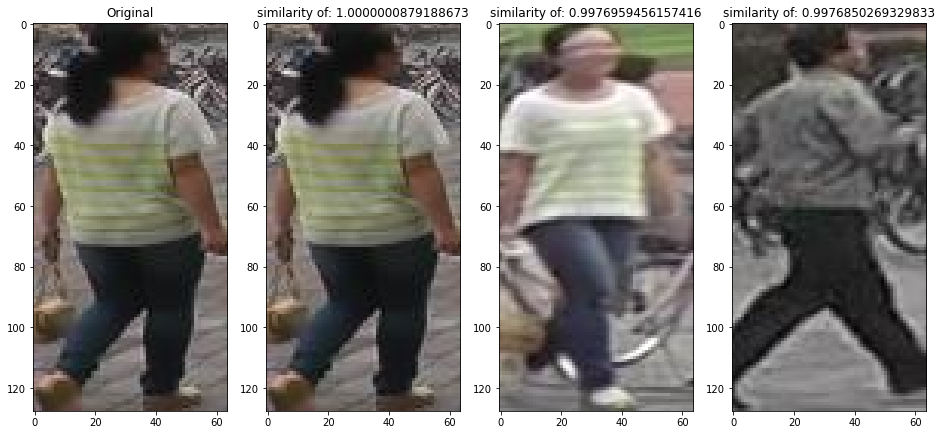

In [78]:
data_path = 'Market_data/Market-1501-v15.09.15/bounding_box_test'
display_similar(scores, ids, data_path, 30)

Nous avons réussi à retrouver la personne de même identité (la 3ème image), même depuis un point de vue différent (caméra différente), et ce avec uniquement 3 epochs, la prédiction pourra s'améliorer davantage en ajoutant plus d'expériences, pour aussi minimiser la similarité avec l'exemple négatif. 

La première image la plus similaire correspond bien entendu à l'image originale (même vecture, donc la produit scalaire = 1), dans le calcul du recall@1, on vérifie bien que la bonne réponse n'est pas l'image originale, mais une image différente de même identité.

### Représentation en 2D:
Pour voir mieux l'organisation de l'encodage des images, nous allons représenter cette encoding en 2D:

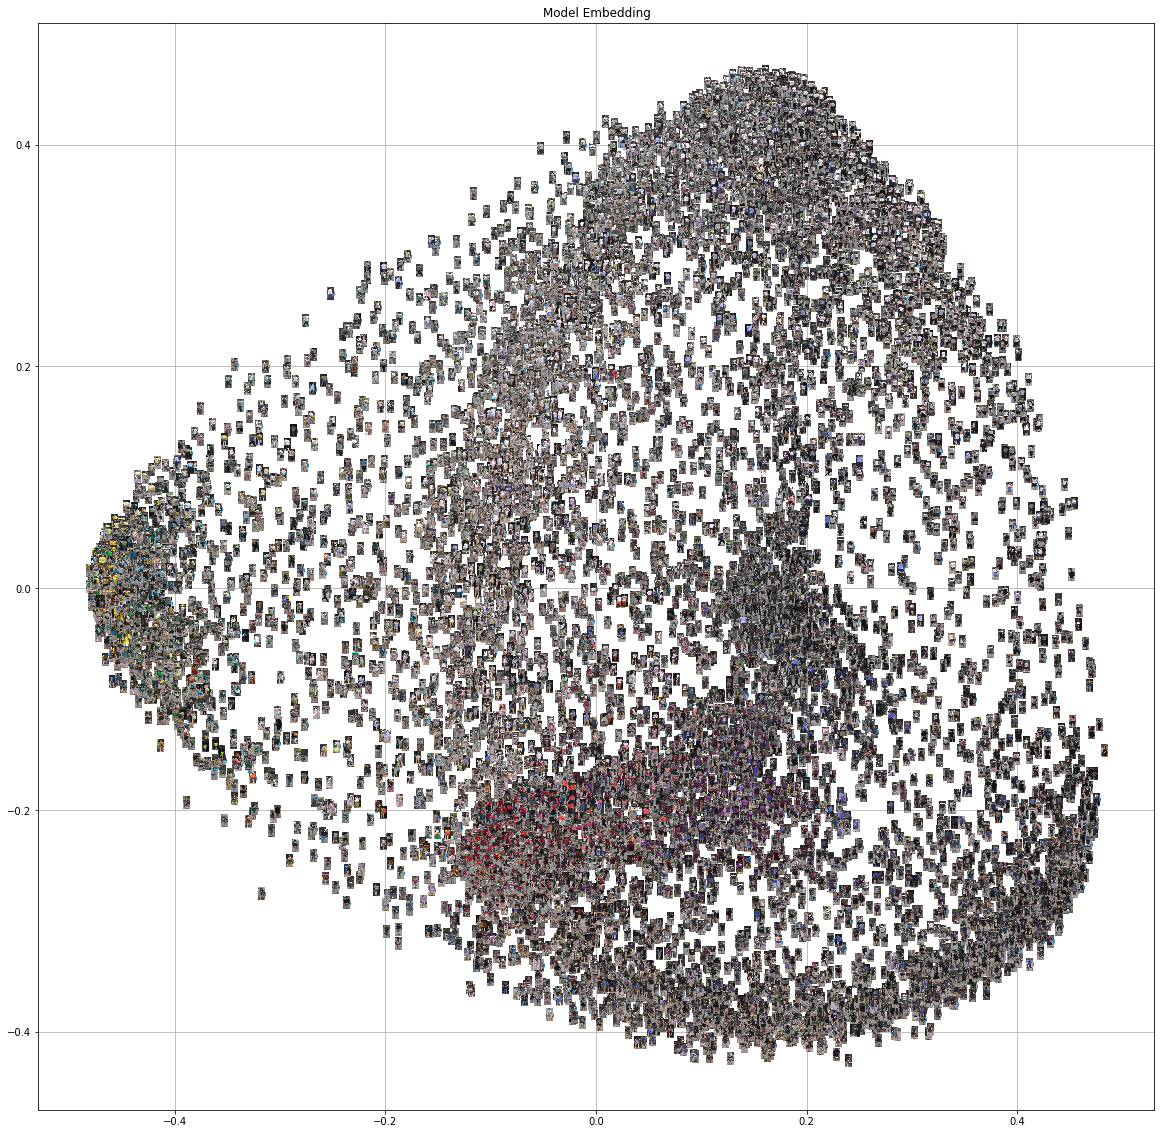

In [66]:
# get encodings
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

def getImage(path, zoom=.1):
    return OffsetImage(plt.imread(path), zoom=zoom)
data_test = 'Market_data/Market-1501-v15.09.15/bounding_box_test'
pca = PCA(n_components=2)
proj = pca.fit_transform(ims)
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)

plt.scatter(proj[:, 0], proj[:, 1])
plt.grid()
plt.title("Model Embedding")
paths = os.listdir(data_test)
for x0, y0, path in zip(proj[:, 0], proj[:, 1], paths):
    ab = AnnotationBbox(getImage(os.path.join(data_test,path)), (x0, y0), frameon=False)
    ax.add_artist(ab)

### Encoder avec un modèle pré-entrainé:

Pour utiliser un modèle entraîné et sauvegardé, il suffit de créer une instance de ReIdModel, y importer les poids du fichier .PTH et encoder les données avec:

In [73]:
checkpoint = torch.load("model_vgg19.PTH")
model = ReIdModel(options)
model.load_state_dict(checkpoint)
model.logger = LogCollector()
ims, ids, r1 = encode_data(model, val_loader)

encoding...


100%|██████████| 132/132 [01:58<00:00,  1.11it/s]


mean recall@1 on batches of validation:  88.81060606060606


##__Conclusion__:

On peut voir que le modèle réussit à bien représenter dans son espace latent les caractéristiques qui différencient les personnes, notamment leur vêtements. Ceci pourrait induire des négatifs dûrs (identité différente, vêtements semblables), mais notre loss est construite pour éloigner ces exemples négatifs. L'article souligne le fait que pénaliser que les exemples négatifs simples (différentes identité), ou pénaliser que les exemples négatifs dûrs (identité différentes, mais les plus semblables dans le dataset en entier) conduisent à des problèmes de convergences. Cette approche consiste à pénaliser que les exemples négatifs, dans le batch (et non le dataset en entier). Ces exemples seront considérés négatifs **modérés**, un compromis entre les deux approches. On a donc un recall@1 moyen par batch supérieur au recall@1 sur le dataset, ce qui est normal et confirme la nécessité de plus d'expériences.